In [1]:
""" goal: set up model based analysis.
"""

%load_ext autoreload
%autoreload 2

from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *

NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify


In [2]:
animal = "Pancho";
date = 200226
expt = "pilot"
session = 1

from tools.preprocess import *
filedata = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                      resave_overwrite=False)

from tools.utils import *
getMultTrialsTaskStages(filedata)

found one matching filename: ['/data2/animals/Pancho/200226/200226_121930_pilot_Pancho_1.h5']
found one matching filename: ['/data2/animals/Pancho/200226/200226_121930_pilot_Pancho_1.pkl']
-- loaded presaved data: /data2/animals/Pancho/200226/200226_121930_pilot_Pancho_1.pkl
got 617 total trials


{'line': 116,
 'two_lines_anywhere': 256,
 'one_dot': 28,
 'circle_partial': 172,
 'line_natural': 6,
 'two_lines_natural': 20,
 'three_lines_natural': 19}

In [3]:
# -- collect d## FILTER TO FIND GOOD TRIALS, - PLOT THOSE
# --- for a given set of trials, collect trajectories for all of them

targ = {
    "task_stage":["two_lines_anywhere"],
    "fracsuccess_min":[0.25]
}

trials_list = getIndsTrials(filedata, targ)
trials_list = removeRedundantTrials(filedata, trials_list)

got 159 total trials
THIS NOT OPTIMAL - see notes. is ok if same tasks always occur in direct succession chron order.
started with 159 trials
ended with 93 trials


In [ ]:
# -- overview
plotMultTrialsSimple(filedata, trials_list, zoom=True) 


In [4]:
def _getStrokeDict():
    # 1) load and preprocess
    stroke_dict = getMultTrialsStrokeDict(filedata, trials_list)
    # 2) remove short segments
    stroke_dict = processRemoveShortStrokes(stroke_dict)
    return stroke_dict

stroke_dict = _getStrokeDict()
# 3) reorder task strokes
stroke_dict = processReorderStrokes(stroke_dict, filedata)
# 4) update timestamps
stroke_dict = processFakeTimesteps(stroke_dict, filedata, key_to_do="strokes_all_task", ver="from_first_touch",
                                  replace_key_to_do=True)
stroke_dict = processFakeTimesteps(stroke_dict, filedata, key_to_do="strokes_all_task", ver="from_end_of_previous_stroke",
                                  replace_key_to_do=True)
# 5) get angles of task
stroke_dict = processAngles(stroke_dict, stroke_to_use="first", force_use_two_points=True)



[getTrialsStrokes] removing stroke for calc vel since shorter than window
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime


In [9]:
def _plots(stroke_dict):

# --
# ALIGN_BY = "onset_task"
# ROTATE_BY = "task_first_stroke"
# SCALE_BY = "task_first_stroke"

# == 1) Plot in original space, trials + first touch point

# plot a few example trials, behavior and model

    # plot density on canvas of first touch (untransformed)
    ax = plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all_task", 
                          title="", strokes_to_plot="first_touch", 
                         plotver=[1,0,0])
    plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all", 
                          title="first touch (mod=r, sub=b)", strokes_to_plot="first_touch", 
                         plotver=[0,0,1], ax=ax)

    # plot beh first stroke vs. model first stroke (predictions)
    ax = plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all_task", 
                          title="", strokes_to_plot="first", 
                         plotver=[1,0,0], alpha_force=0.1)
    plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all", 
                          title="first stroke (mod=r, sub=b)", strokes_to_plot="first", 
                         plotver=[0,0,1], ax=ax, alpha_force=0.02)
        

    # plot position of subject first touch relative to model first touch 
    # (transformed so model first stroke going up)
    ALIGN_BY = "onset_task"
    ROTATE_BY = "task_first_stroke"
    SCALE_BY = ""
    
    
    ax = plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all_task", 
                          title="", strokes_to_plot="first", 
                         plotver=[1,0,0], alpha_force=0.1, align_by=ALIGN_BY,
                              rotate_by=ROTATE_BY, scale_by=SCALE_BY)
    plotDictCanvasOverlay(stroke_dict, filedata, "strokes_all", 
                          title="first touch (mod=r, sub=b)", strokes_to_plot="first_touch", 
                         plotver=[0,0,1], ax=ax, alpha_force=0.3, align_by=ALIGN_BY,
                              rotate_by=ROTATE_BY, scale_by=SCALE_BY)


    # plot the correlation between stroke numbers [i.e., matching strokes]
    # compares the behavior with the top matching sequence for model
    dat = []
    for stroke_assignments in stroke_dict["stroke_assignments_all"]:
        for i in range(len(stroke_assignments)):
            dat.append({
                "snum":i,
                "snum_assigned":stroke_assignments[i],
                "nstrokes":len(stroke_assignments)})

    import pandas as pd
    import seaborn as sns
    
    for d in dat:
        d["diff"]=abs(d["snum"]-d["snum_assigned"])
    
    df = pd.DataFrame(dat)
#     sns.catplot(x="snum", y="snum_assigned", data=df, hue="nstrokes", kind="swarm", 
#                 dodge=False)
    g = sns.jointplot("snum", "snum_assigned", data=df, kind="hex")

    g = sns.FacetGrid(df, margin_titles=True)
    g.map(plt.hist, "diff", color="steelblue")
    plt.xlabel('abs diff, stroke num vs. assigned')
    
    # should do this: https://python-graph-gallery.com/91-customize-seaborn-heatmap/
#     sns.heatmap(pd.Array(df[["snum", "snum_assigned"]]))
    if False:
        g = sns.FacetGrid(df, col="snum", margin_titles=True)
        g.map(plt.heatmap, "snum_assigned", color="steelblue")
    
    
    # plot position of subject first touch (second stroke) relative to model ...

    
    # -- plot model-based distances
    scores_post = stroke_dict["posterior_scores"]
    plt.figure()
    plt.xlabel('posterior scores')
    plt.ylabel('num trials')
    plt.hist(scores_post, bins=100)
    

[getTrialsStrokes] removing stroke for calc vel since shorter than window
THIS IS SLOW - rewrite to just get the orders, without getting the distances
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime
[getTrialsStrokes] removing stroke for calc vel since shorter than window
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime
[getTrialsStrokes] removing stroke for calc vel since shorter than window
THIS IS SLOW - rewrite to just get the orders, without getting the distances
NOTE: replaced strokes_all_task with values in strokes_all_task_faketime


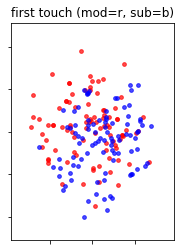

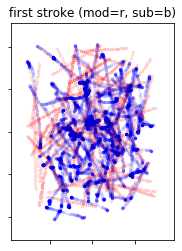

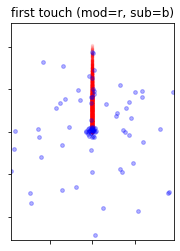

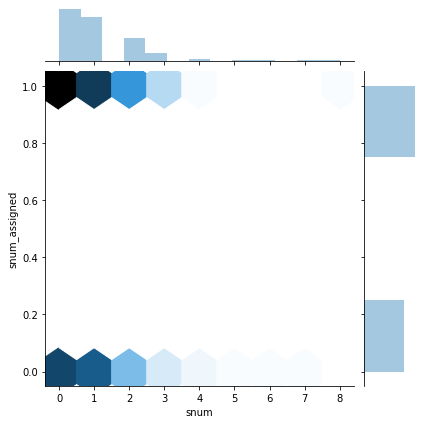

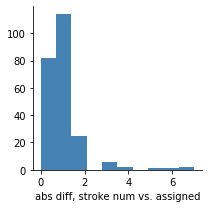

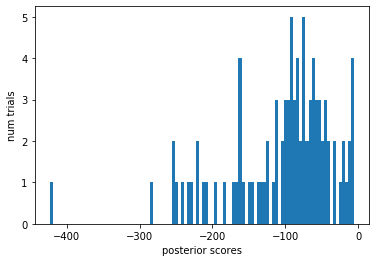

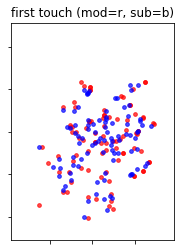

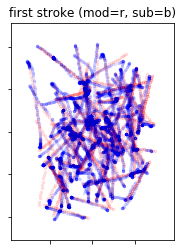

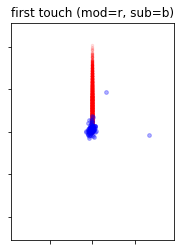

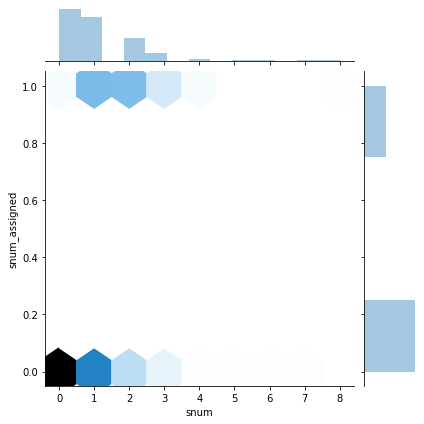

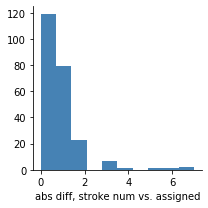

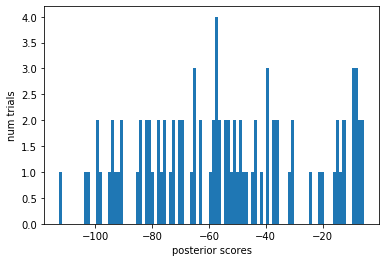

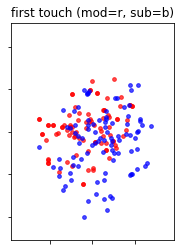

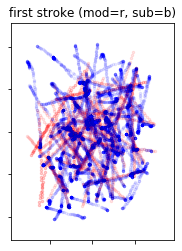

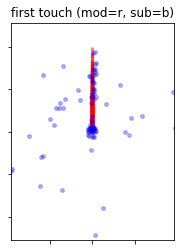

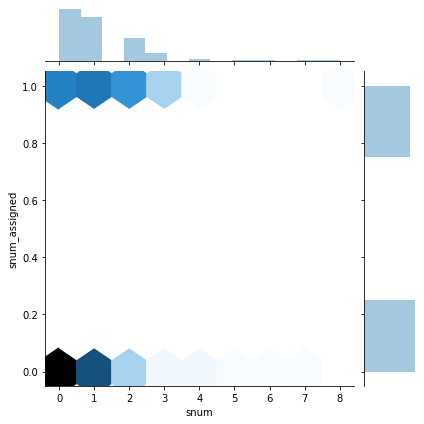

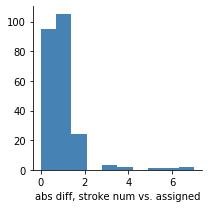

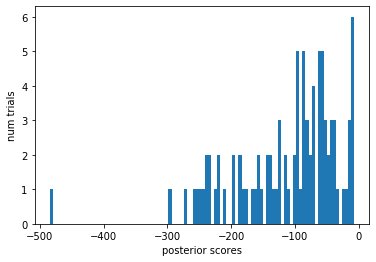

In [10]:
    
##########################################
VER = "v1" # change this to v2 once coded up.

PARAMS = []
PARAMS.append({
    "method_prior":"uniform",
    "method_likeli":'DTW_modHausdorff',
    "method_post":'top1',
})

EXPTS = []
POST_SCORES = []

# ============= 0) DEFAULT - meaningless.. just sanity check fro rest of code
stroke_dict = _getStrokeDict()
# i) reorder all of the task strokes [i.e., based on a model]
stroke_dict = processReorderStrokes(stroke_dict, filedata, method="uniform",
                                         reassign_timestamps=False)
# ii) reassign time stamps for task strokes, so that start clesest to origin
stroke_dict = processFakeTimesteps(stroke_dict, filedata, ver="from_orig", replace_key_to_do=True)
# iii) gets angles of strokes
stroke_dict = processAngles(stroke_dict)
# iv) assign each subject stroke to a task stroke
stroke_dict = processAssignStrokes(stroke_dict, ver=VER)
# v) get beh-model distances (posterior scores)
stroke_dict = processPosteriorScores(stroke_dict, filedata, method_prior="uniform")

# --- PLOTS:
_plots(stroke_dict)
EXPTS.append("uniform")
POST_SCORES.append(stroke_dict["posterior_scores"])


## ============= POSITIVE CONTROL
stroke_dict = _getStrokeDict()
# i) reorder all of the task strokes [i.e., based on a model]
stroke_dict = processReorderStrokes(stroke_dict, filedata, method="distance",
                                         reassign_timestamps=False)
# ii) reassign time stamps for task strokes, so that match behavior best
stroke_dict = processFakeTimesteps(stroke_dict, filedata, ver="from_first_touch", replace_key_to_do=True)
stroke_dict = processFakeTimesteps(stroke_dict, filedata, ver="from_end_of_previous_stroke", replace_key_to_do=True)
# iii) gets angles of strokes
stroke_dict = processAngles(stroke_dict)
# iv) assign each subject stroke to a task stroke
stroke_dict = processAssignStrokes(stroke_dict, ver=VER)
# v) get beh-model distances (posterior scores)
stroke_dict = processPosteriorScores(stroke_dict, filedata, method_prior="distance")

# --- PLOTS:
_plots(stroke_dict)
EXPTS.append("positive_control")
POST_SCORES.append(stroke_dict["posterior_scores"])


# ============= 1) Touch closest line and closest point
stroke_dict = _getStrokeDict()
# i) reorder all of the task strokes [i.e., based on a model]
stroke_dict = processReorderStrokes(stroke_dict, filedata, method="prox_to_origin",
                                         reassign_timestamps=False)
# ii) reassign time stamps for task strokes, so that start clesest to origin
stroke_dict = processFakeTimesteps(stroke_dict, filedata, ver="from_orig", replace_key_to_do=True)
# iii) gets angles of strokes
stroke_dict = processAngles(stroke_dict)
# iv) assign each subject stroke to a task stroke
stroke_dict = processAssignStrokes(stroke_dict, ver=VER)
# v) get beh-model distances (posterior scores)
stroke_dict = processPosteriorScores(stroke_dict, filedata, method_prior="prox_to_origin")

# --- PLOTS:
_plots(stroke_dict)
EXPTS.append("closest_line_point")
POST_SCORES.append(stroke_dict["posterior_scores"])


# ============= [GOOD] Touch closest line, constrained to be efficient on that line
# for directions, use empirical probabilities


# ============= [GOOD] Constrain entire sequence to be most efficient


## TODO:
# 1) NOTE: NEED TO INCORPORATE DIRECTIONALITY OF STROKES? can chop up strokes into half to do that.
# Yes, split strokes up.
# 2) DTW
# 3) not just top1 posterior
# 4) rewrite more cleanly (prior, likeli, posterior) 


In [152]:
a = [1,2,3]

tuple(a)

(1, 2, 3)

In [125]:
np.zeros((len([0,0,0]),1))

array([[0.],
       [0.],
       [0.]])

In [117]:
np.argmax(np.zeros((3,)))
np.random.choice(np.flatnonzero(b == b.max()))

2

In [92]:
from tools.analy import processScoreReorderedStrokes
stroke_dict = _getStrokeDict()
stroke_dict = processScoreReorderedStrokes(stroke_dict, filedata)
print(stroke_dict["behtask_taskorders_all"][0])
stroke_dict["scores_taskorders_all"][0]

NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify
[getTrialsStrokes] removing stroke for calc vel since shorter than window


KeyError: 'behtask_taskorders_all'

In [ ]:
# --- plot all the orderings
import random
trial = random.randint(1, len(stroke_dict["behtask_taskorders_all"]))

strokes = stroke_dict["strokes_all_task"][trial]
for orders, scores in zip(stroke_dict["behtask_taskorders_all"][trial],
                          stroke_dict["scores_taskorders_all"][trial]):
    strokes_this = [strokes[i] for i in orders]
    strokes_this = fakeTimesteps(strokes_this, [], ver="in_order")
    ax = plotTrialSimple(filedata, 1, plotver="empty")[0]
    plotDatStrokes(strokes_this, ax=ax, plotver="strokes")
    plt.title(f"score, this order, {scores}")

In [ ]:
np.diff([3,4])